In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mthree

# Importing standard Qiskit libraries
from qiskit import execute, IBMQ, QuantumCircuit, transpile, assemble, Aer, ClassicalRegister, QuantumRegister

from qiskit.circuit import Parameter, ParameterVector
from qiskit.transpiler.coupling import CouplingMap
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import QFT, RealAmplitudes
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.converters.circuit_to_dag import circuit_to_dag


from qiskit.providers.ibmq import IBMQ
from qiskit.providers.aer import AerSimulator


IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='columbia-uni-1', project='main')

from qiskit.providers.fake_provider import FakeOslo
backend = AerSimulator.from_backend(FakeOslo())

In [2]:
%run utils.py 

In [3]:
class bin_tree:
    size = None
    values = None

    def __init__(self, values):
        self.size = len(values)
        self.values = values

    def parent(self, key):
        return int((key-0.5)/2)

    def left(self, key):
        return int(2 * key + 1)

    def right(self, key):
        return int(2 * key + 2)

    def root(self):
        return 0

    def __getitem__(self, key):
        return self.values[key]
    
class Encoding:
    qcircuit = None
    quantum_data = None
    classical_data = None
    num_qubits = None
    tree = None
    output_qubits = []

    def __init__(self, input_vector, encode_type='amplitude_encoding'):
        if encode_type == 'amplitude_encoding':
            self.amplitude_encoding(input_vector)
        if encode_type == 'qubit_encoding':
            self.qubit_encoding(input_vector)
        if encode_type == 'dc_amplitude_encoding':
            self.dc_amplitude_encoding(input_vector)
        if encode_type == 'basis_encoding':
            self.basis_encoding(input_vector)
    
    def basis_encoding(self, input_vector, n_classical=1):
        """
        encoding a binary string x in a basis state |x>
        """
        self.num_qubits = int(len(input_vector))
        self.quantum_data = qiskit.QuantumRegister(self.num_qubits)
        self.classical_data = qiskit.ClassicalRegister(n_classical)
        self.qcircuit = qiskit.QuantumCircuit(self.quantum_data, self.classical_data)
        for k, _ in enumerate(input_vector):
            if input_vector[k] == 1:
                self.qcircuit.x(self.quantum_data[k])


    def qubit_encoding(self, input_vector, n_classical=1):
        """
        encoding a binary string x as
        """
        input_pattern = qiskit.QuantumRegister(len(input_vector))
        classical_register = qiskit.ClassicalRegister(n_classical)
        self.qcircuit = qiskit.QuantumCircuit(input_pattern, classical_register)
        for k, _ in enumerate(input_vector):
            self.qcircuit.ry(input_vector[k], input_pattern[k])
            
    @staticmethod
    def _recursive_compute_beta(input_vector, betas):
        if len(input_vector) > 1:
            new_x = []
            beta = []
            for k in range(0, len(input_vector), 2):
                norm = np.sqrt(input_vector[k] ** 2 + input_vector[k + 1] ** 2)
                new_x.append(norm)
                if norm == 0:
                    beta.append(0)
                else:
                    if input_vector[k] < 0:
                        beta.append(2 * np.pi - 2 * np.arcsin(input_vector[k + 1] / norm)) ## testing
                    else:
                        beta.append(2 * np.arcsin(input_vector[k + 1] / norm))
            Encoding._recursive_compute_beta(new_x, betas)
            betas.append(beta)
            output = []
    
    @staticmethod
    def _index(k, circuit, control_qubits, numberof_controls):
        binary_index = '{:0{}b}'.format(k, numberof_controls)
        for j, qbit in enumerate(control_qubits):
            if binary_index[j] == '1':
                circuit.x(qbit)


    def amplitude_encoding(self, input_vector):
        """
        load real vector x to the amplitude of a quantum state
        """
        self.num_qubits = int(np.log2(len(input_vector)))
        self.quantum_data = qiskit.QuantumRegister(self.num_qubits)
        self.qcircuit = qiskit.QuantumCircuit(self.quantum_data)
        newx = np.copy(input_vector)
        betas = []
        Encoding._recursive_compute_beta(newx, betas)
        self._generate_circuit(betas, self.qcircuit, self.quantum_data)
        
    def dc_amplitude_encoding(self, input_vector):
        self.num_qubits = int(len(input_vector))-1
        self.quantum_data = qiskit.QuantumRegister(self.num_qubits)
        self.qcircuit = qiskit.QuantumCircuit(self.quantum_data)
        newx = np.copy(input_vector)
        betas = []
        Encoding._recursive_compute_beta(newx, betas)
        self._dc_generate_circuit(betas, self.qcircuit, self.quantum_data)

    def _dc_generate_circuit(self, betas, qcircuit, quantum_input):

        k = 0
        linear_angles = []
        for angles in betas:
            linear_angles = linear_angles + angles
            for angle in angles:
                qcircuit.ry(angle, quantum_input[k])
                k += 1

        self.tree = bin_tree(quantum_input)
        my_tree = self.tree

        last = my_tree.size - 1
        actual = my_tree.parent(last)
        level = my_tree.parent(last)
        while actual >= 0:
            left_index = my_tree.left(actual)
            right_index = my_tree.right(actual)
            while right_index <= last:

                qcircuit.cswap(my_tree[actual], my_tree[left_index], my_tree[right_index])

                left_index = my_tree.left(left_index)
                right_index = my_tree.left(right_index)
            actual -= 1
            if level != my_tree.parent(actual):
                level -= 1

        # set output qubits
        next_index = 0
        while next_index < my_tree.size:
            self.output_qubits.append(next_index)
            next_index = my_tree.left(next_index)

    def _generate_circuit(self, betas, qcircuit, quantum_input):
        numberof_controls = 0  # number of controls
        control_bits = []
        for angles in betas:
            if numberof_controls == 0:
                qcircuit.ry(angles[0], quantum_input[self.num_qubits-1])
                numberof_controls += 1
                control_bits.append(quantum_input[self.num_qubits-1])
            else:
                for k, angle in enumerate(reversed(angles)):
                    Encoding._index(k, qcircuit, control_bits, numberof_controls)

                    qcircuit.mcry(angle,
                                  control_bits,
                                  quantum_input[self.num_qubits - 1 - numberof_controls],
                                  None,
                                  mode='noancilla')

                    Encoding._index(k, qcircuit, control_bits, numberof_controls)
                control_bits.append(quantum_input[self.num_qubits - 1 - numberof_controls])
                numberof_controls += 1

/tmp/ipykernel_60/3096159528.py:69: DeprecationWarning: 'Bit.index' is deprecated since Qiskit Terra 0.17 and will be removed in a future release. Bits may be in more than one register. Use 'QuantumCircuit.find_bit' to find all the containing registers within a circuit, and the index of the bit within the circuit.
  one_minus_error *= 1 - backend.properties().gate_property('cx')[(initial_layout[ii][1][0].index, initial_layout[ii][1][1].index)]['gate_error'][0]


Circuit: 0# CX gates:  7
1-error of circ 0 0.9488332880262549
Circuit: 0# CX gates:  7
1-error of circ 0 0.9488332880262549
Circuit: 1# CX gates:  9
1-error of circ 1 0.9326538855326375
Circuit: 1# CX gates:  7
1-error of circ 1 0.9488332880262549
Circuit: 1# CX gates:  7
1-error of circ 1 0.9488332880262549
Circuit: 2# CX gates:  7
1-error of circ 2 0.9488332880262549
Circuit: 2# CX gates:  7
1-error of circ 2 0.9488332880262549
Circuit: 3# CX gates:  9
1-error of circ 3 0.9326538855326375
Circuit: 3# CX gates:  9
1-error of circ 3 0.9344449358860557
Circuit: 3# CX gates:  9
1-error of circ 3 0.9326538855326375
Circuit: 3# CX gates:  9
1-error of circ 3 0.9326538855326375
Circuit: 3# CX gates:  7
1-error of circ 3 0.9488332880262549
Circuit: 3# CX gates:  7
1-error of circ 3 0.9488332880262549
Circuit: 4# CX gates:  7
1-error of circ 4 0.9488332880262549
Circuit: 4# CX gates:  7
1-error of circ 4 0.9488332880262549
Circuit: 5# CX gates:  9
1-error of circ 5 0.9344449358860557
Circuit:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


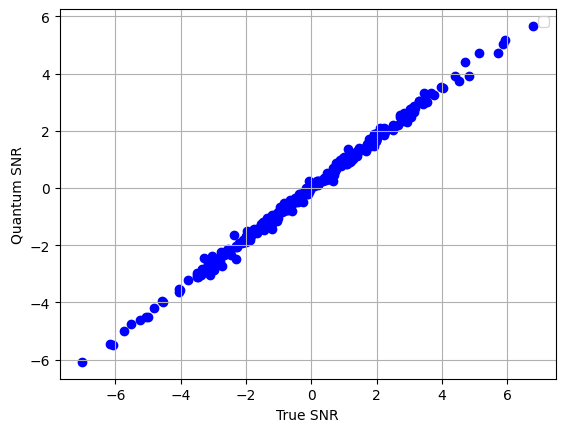

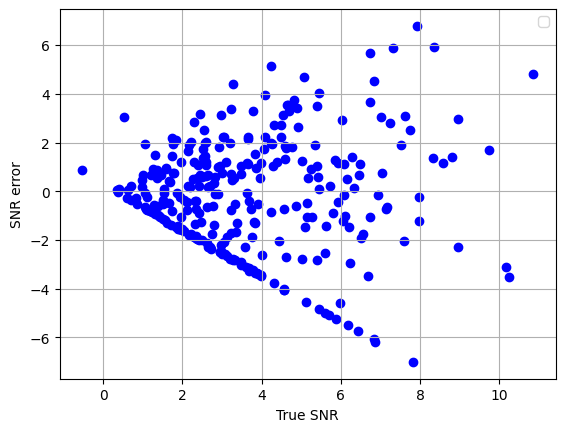

In [27]:
def sub_circ(w_: np.ndarray, h_: np.ndarray):   
    qr = QuantumRegister(4)
    cr = ClassicalRegister(3)
    qc = QuantumCircuit(qr, cr)
    
    #data
    betas_d = []
    angles_d = []
    Encoding._recursive_compute_beta(w_, betas_d) 
    for alist in betas_d:
        angles_d += alist

    #signal
    betas_s = []
    angles_s = []
    Encoding._recursive_compute_beta(h_, betas_s) 
    for alist in betas_s:
        angles_s += alist  
    
    #add r circuits
    for k, val in enumerate(angles_d):
        qc.ry(val, k)

    for k, val in enumerate(angles_s): 
        qc.ry(val, k+3)
    
    qc.cx(1,2)
    qc.ccx(0,2,1)
    qc.measure([0,1,3], [0,1,2])  
    
    return qc

# classical_snr = []
# quantum_snr = []
# for k in range(0, 2):
h_features1 = np.array([2, -1])
signalshift = -min(h_features1) + 0.1 
h_features = (h_features1 + signalshift) ** 0.5  
h_features = h_features / np.linalg.norm(h_features)

#data
dd = np.zeros((100, 4))
datashift = np.zeros((100, 4))
data = np.zeros((100, 4))
    
for i in range(0, 100):
    dd[i] = np.random.normal(0, 1, 4)
    datashift[i] = -min(dd[i]) + 0.1
    data[i] = (dd[i] + datashift[i]) ** 0.5 #don't normalize yet   

    
circuit_lists = []
for i in range(0, 100): 
        
    #break data into parts
    w_features = data[i]
    w_features = w_features / np.linalg.norm(w_features)
        
    #get subcircuit
    qc_sub = sub_circ(w_features, h_features)
        
    #To create correct circuit
    while True: 
        trans_circ = transpile(qc_sub, backend=backend, optimization_level=3)
        initial_layout = trans_circ
        one_minus_error=1
        for ii in range(len(initial_layout) - 1):
            if(len(initial_layout[ii][1]) == 2):
                one_minus_error *= 1 - backend.properties().gate_property('cx')[(initial_layout[ii][1][0].index, initial_layout[ii][1][1].index)]['gate_error'][0]
        print('Circuit: '+str(i) + '# CX gates: ', trans_circ.count_ops()['cx'])
        print('1-error of circ '+str(i), one_minus_error)
        if (trans_circ.count_ops()['cx']<=7 and one_minus_error > 0.92):
            print('Circuit: '+str(i)+'# CX gates: ', trans_circ.count_ops()['cx'])
            print('1-error of circ '+str(i), one_minus_error)
            break
            
    circuit_lists.append(trans_circ)

    
    
results = execute(circuit_lists, backend, shots=20000).result()
countsa = results.get_counts() 
# print(countsa)
table =['000','110','010','101','001','111']
# table =['000', '001', '010', '011', '100', '101','110','111']
    
q4 = np.zeros((100,3))
cl4 = np.zeros((100,3))
qp4 = np.zeros((100,3))
clp4 = np.zeros((100,3))
corr = np.zeros((100,3))
    
for j in range(0, 100): 
    counts = countsa[j] 
    
    for i in range(0, 3):  
        w_features = data[j][i:i+2]
        w_features = w_features / np.linalg.norm(w_features)
        
        w_features1 = data[j][i:i+2] ** 2 - datashift[j][0]
        
        
        # w_features = w_features / np.linalg.norm(w_features)
        # w_features1 = data[i:i+2]**2-datashift
        qp4[j][i]=((counts[table[2*i]]+counts[table[2*i+1]])/(20000))
        clp4[j][i]=(np.dot(dd[j][i:i+2], h_features1) + np.sum(datashift[j][0]*h_features1 + signalshift*w_features1 + datashift[j][0]*signalshift)) / (np.linalg.norm((h_features1+signalshift)**0.5)**2*np.linalg.norm(data[j])**2)
        q4[j][i]= ((counts[table[2*i]]+counts[table[2*i+1]])/(20000)) * np.linalg.norm((h_features1+signalshift)**0.5)**2 * np.linalg.norm(data[j])**2 - np.sum(datashift[j][0]*h_features1+signalshift*w_features1+datashift[j][0]*signalshift)
        cl4[j][i]=(np.dot(dd[j][i:i+2], h_features1))
        corr[j][i]= (np.sum(datashift[j][0]*h_features1 + signalshift*w_features1 + datashift[j][0]*signalshift))

# print(qp4)
# print(clp4)


plt.figure()
plt.scatter(cl4, q4, color="blue") 
plt.xlabel('True SNR')
plt.ylabel('Quantum SNR')
plt.legend()
plt.grid()

plt.figure()
plt.scatter(corr, cl4, color="blue") 
plt.xlabel('True SNR')
plt.ylabel('SNR error')
plt.legend()
plt.grid()
    
# plt.figure()  
# plt.scatter(np.arange(len(q4)), qp4[:, 0], color="red")
# plt.scatter(np.arange(len(q4)), qp4[:, 1], color="red")
# plt.scatter(np.arange(len(q4)), qp4[:, 2], color="red")
# plt.scatter(np.arange(len(q4)), clp4[:, 0], color="blue")
# plt.scatter(np.arange(len(q4)), clp4[:, 1], color="blue")
# plt.scatter(np.arange(len(q4)), clp4[:, 2], color="blue")

# plt.xlabel('Sample number')
# plt.ylabel('Prob')
# plt.legend()
#plt.grid()
